# **Welcome to CME 500!**

Imagine you are a police officer making an arrest. After charging the defendant with a crime, you may either hold them in jail until their trial or release them (a "pre-trial release"). How should you make this decision? 

In this first notebook, we will train a model to estimate the likelihood that someone who is arrested will reoffend. We will then interpret the output of our model and ask if it is fair.

This notebook is based on HW 7 and 8 from Sharad Goel's class [Law, Bias, and Algorithms](https://github.com/stanford-policylab/law-bias-algo).

COMPAS is a risk assessment tool that is currently being used in several jurisdictions to decide pre-trial release. In 2016, ProPublica wrote an [article](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) criticising the fairness of COMPAS's scores against minorities and women. The data we will use in this notebook is a cleaned version of their dataset.

First, run the below cell to obtain a copy of the COMPAS data.

In [0]:

library(tidyverse)

# Settings ----------------------------------------------------------------
options(digits = 3)
options(warn = -1)
theme_set(theme_bw())
options(repr.plot.width = 6, repr.plot.height = 4)


# Original, full COMPAS data from ProPublica
SOURCE_CSV <- "https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years.csv"
TARGET_RDS <- "compas.rds"

# Read data ---------------------------------------------------------------
origin_df <- read_csv(SOURCE_CSV)

cat(sprintf("Starting with %.0f rows\n", nrow(origin_df)))

# Rename/normalize columns ------------------------------------------------
cn <- colnames(origin_df)

# Process and clean -------------------------------------------------------
clean_df <- origin_df %>%
  filter(race %in% c("Caucasian", "African-American")) %>%
  select(id, sex, dob, age, race,
         recid_score = decile_score,
         violence_score = v_decile_score,
         priors_count,
         is_recid,
         is_violent_recid) %>%
  filter(complete.cases(.))

# Save --------------------------------------------------------------------
# Save data
message("\nSaving clean data file to:", TARGET_RDS)
write_rds(clean_df, TARGET_RDS)

# Read the data
compas_df <- read_rds("compas.rds")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Parsed with column specification:
cols(
  .default = col_character(),
  id = col_double(),
  compas_screening_date = col_date(format = ""),
  dob = col_date(format = ""),
  age = col_double(),
  juv_fel_count = col_double(),
  decile_score = col_double(),
  juv_misd_count = col_double(),
  juv_other_count = col_double(),
  priors_count = col_double(),
  days_b_screening_arrest = col_double(),
  c_jail_in = col_datetime(format = ""),
  c_jail_out = col_datetime(format = ""),
  c_offense_date = col_date(format = ""),
  c_arrest_date = col_date(format = ""),
  c_days_from_compas = col_double(),
  is_recid = co

Starting with 7214 rows



Saving clean data file to:compas.rds



We can see the structure of this dataset below:

In [10]:
head(compas_df)

id,sex,dob,age,race,recid_score,violence_score,priors_count,is_recid,is_violent_recid,risk,pred_recid,compas_pred_recid
<dbl>,<chr>,<date>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
3,Male,1982-01-22,34,African-American,3,1,0,1,1,0.365,FALSE,FALSE
4,Male,1991-05-14,24,African-American,4,3,4,1,0,0.641,TRUE,TRUE
5,Male,1993-01-21,23,African-American,8,6,1,0,0,0.535,TRUE,TRUE
8,Male,1974-07-23,41,Caucasian,6,2,14,1,0,0.800,TRUE,TRUE
10,Female,1976-06-03,39,Caucasian,1,1,0,0,0,0.311,FALSE,FALSE
13,Male,1994-06-10,21,Caucasian,3,5,1,1,1,0.559,TRUE,FALSE


We will train a model to predict the likelihood that an individual will re-offend within two years of their arrest (`` is_recid ``). Our model will be blind to both the race and gender of the accused: it will only see their age (``age``) and the number of prior convictions (``priors_count``).

In [0]:
#logistic regression
recid_model <- glm(is_recid ~ priors_count + age, data = compas_df, family = "binomial")

Given the estimate of risk generated by this model, we can make definite predictions by setting a risk threshold. For now, we will set this threshold at 50%. We also compare our model to COMPAS (a COMPAS score of 4 coresponds roughly to a 50% risk of reoffense). We also generate an integer 1-10 score similar to COMPAS (``risk_bin``) for later.

In [23]:
compas_df <- compas_df %>%
    mutate(
        risk = predict(recid_model, type = "response"),
        risk_bin = round(risk* 10),
        pred_recid = risk >= 0.5,
        compas_pred_recid = recid_score >= 4
    )

# Calculate accuracy
compas_df %>%
    summarize(
        accuracy = mean(pred_recid == is_recid),
        compas_accuracy = mean(compas_pred_recid == is_recid)
    )

accuracy,compas_accuracy
<dbl>,<dbl>
0.675,0.643



**Question:** Our model actually outperforms COMPAS on the given dataset. Would you expect this result to hold on completely new data?

Now, let us check how well calibrated our model is between different genders. Ideally, men and women with similar risks of recidivism should get similar risk scores. Since our model was blind to gender, it should have this property. But does it?

risk_bin,n,Female,Male
<dbl>,<int>,<dbl>,<dbl>
1,127,0.125,0.158
2,519,0.164,0.237
3,690,0.247,0.309
4,943,0.312,0.395
5,1727,0.363,0.486
6,1025,0.632,0.683
7,505,0.759,0.767
8,329,0.714,0.793


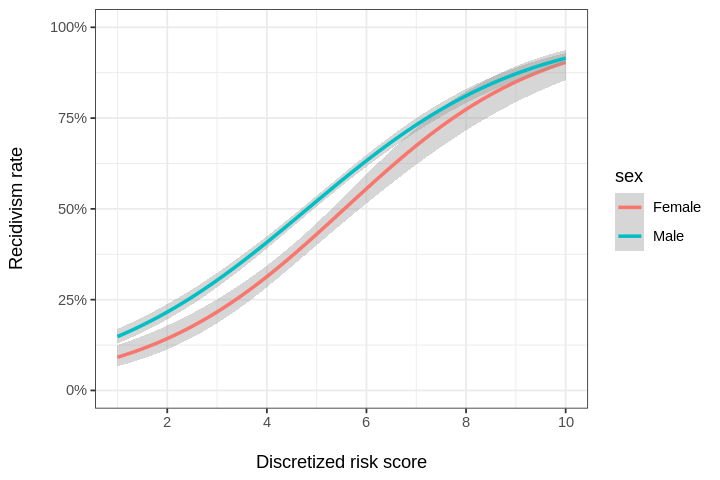

In [18]:
calibration_by_gender <- compas_df %>%

    filter(risk_bin <= 8) %>% #We discard the bins for scores of 9 or 10 as they contain too few individuals
    group_by(sex, risk_bin) %>%
    summarize(
        recidivism_rate = mean(is_recid),
        n = n()
    )

# Put the recidivism rates of different genders side by side
calibration_by_gender %>%
    spread(sex, recidivism_rate) %>%
    group_by(risk_bin) %>%
    summarize(
        n = sum(n),
        Female = first(na.omit(Female)),
        Male = first(na.omit(Male))
    )
ggplot(compas_df, 
       aes(x = risk_bin, y = is_recid, color = sex, group=sex)) + 
    geom_smooth(method="glm", method.args=list(family="binomial")) +
    scale_y_continuous(labels = scales::percent_format(), limits = c(0, 1))+
    scale_x_continuous(breaks = seq(0, 10, 2), limits = c(1, 10))+
    labs(x = "\nDiscretized risk score",
         y = "Recidivism rate\n")

Our model seems to be fairly *unfair* to women! Men with a score of 5 on our model have roughly the same odds of reoffense as women with a score of 5.5. At the lower end of the scale, women are scored roughly **one point** more harshly than men.


**Question:** Can you explain these results? How could a gender-blind model produce this kind of score disparity?

To remedy this scoring discrepancy, we will build another model which is not blind to gender.


Call:
glm(formula = is_recid ~ priors_count + age + sex, family = "binomial", 
    data = compas_df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-3.113  -1.068  -0.431   1.067   2.238  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)   0.79305    0.10227    7.75  8.9e-15 ***
priors_count  0.15836    0.00736   21.53  < 2e-16 ***
age          -0.04802    0.00256  -18.79  < 2e-16 ***
sexMale       0.37449    0.06954    5.39  7.2e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 8525.6  on 6149  degrees of freedom
Residual deviance: 7582.5  on 6146  degrees of freedom
AIC: 7590

Number of Fisher Scoring iterations: 4


unblind_accuracy,blind_accuracy
<dbl>,<dbl>
0.671,0.675


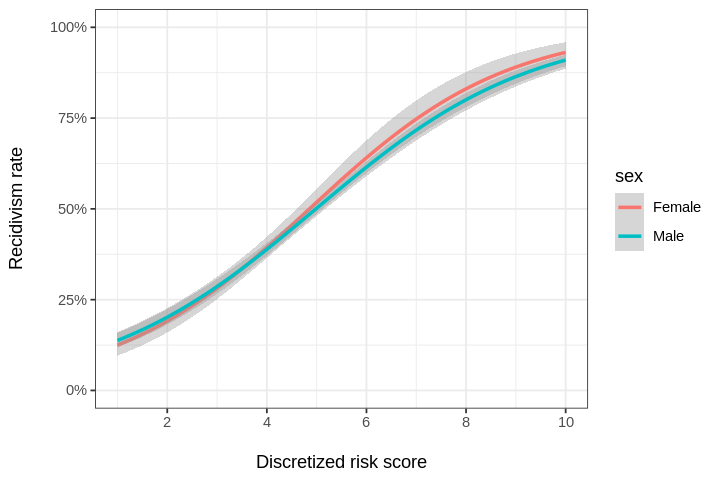

In [25]:
recid_gender_model <- glm(is_recid ~ priors_count + age + sex, data = compas_df, family = "binomial")

# Show model coeffients
summary(recid_gender_model)

compas_df <- compas_df %>%
    mutate(
        gender_specific_risk = predict(recid_gender_model, type = "response"),
        gender_specific_risk_score = round(gender_specific_risk * 10),
        gender_specific_pred_recid = gender_specific_risk >= 0.5
    )

calibration_by_gender <- compas_df %>%
    filter(gender_specific_risk_score <= 8) %>%
    group_by(sex, gender_specific_risk_score) %>%
    summarize(recidivism_rate = mean(is_recid))

ggplot(compas_df, 
       aes(x = gender_specific_risk_score, y = is_recid, color = sex, group=sex)) + 
    geom_smooth(method="glm", method.args=list(family="binomial")) +
    scale_y_continuous(labels = scales::percent_format(), limits = c(0, 1))+
    scale_x_continuous(breaks = seq(0, 10, 2), limits = c(1, 10))+
    labs(x = "\nDiscretized risk score",
         y = "Recidivism rate\n")

compas_df %>%
    summarize(
        unblind_accuracy = mean(gender_specific_pred_recid == is_recid),
        blind_accuracy = mean(pred_recid == is_recid)
    )

Our model is roughly as accurate as it was before, but by taking individuals' gender into account we have virtually eliminated the scoring difference between men and women. 

**Question:** Is this a "fair" model? Would it still be fair if it also took into account race as well?

Now, let us see how our original blind model performs on the basis of race. 

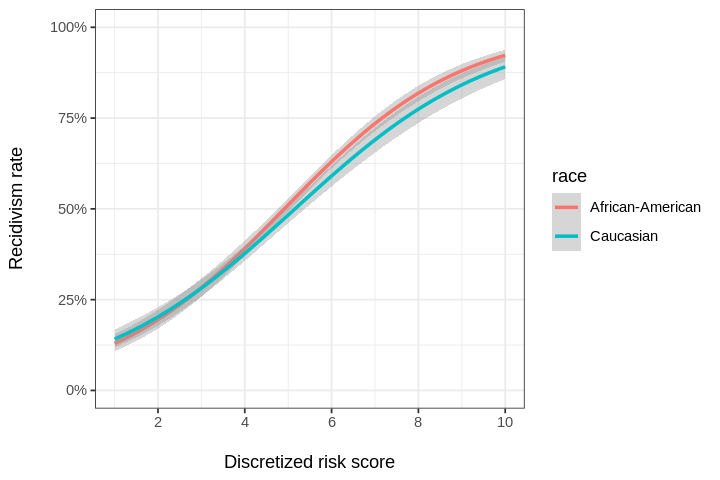

In [30]:
calibration_by_race <- compas_df %>%

    filter(risk_bin <= 8) %>% #We discard the bins for scores of 9 or 10 as they contain too few individuals
    group_by(race, risk_bin) %>%
    summarize(
        recidivism_rate = mean(is_recid),
        n = n()
    )

# Put the recidivism rates of different genders side by side
ggplot(compas_df, 
       aes(x = risk_bin, y = is_recid, color = race, group=race)) + 
    geom_smooth(method="glm", method.args=list(family="binomial")) +
    scale_y_continuous(labels = scales::percent_format(), limits = c(0, 1))+
    scale_x_continuous(breaks = seq(0, 10, 2), limits = c(1, 10))+
    labs(x = "\nDiscretized risk score",
         y = "Recidivism rate\n")

Our model looks reasonably well calibrated on the basis of race. However, let us now investigate how the risk scores for black defendants and white defendants compare to each other. We set the detention threshold at 50% like before.

race,detention_rate
<chr>,<dbl>
African-American,0.604
Caucasian,0.347


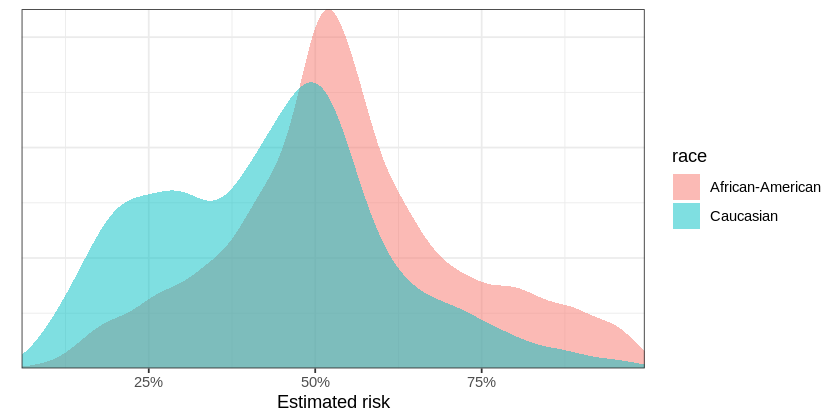

In [31]:
compas_df %>%
    mutate(detained = risk > 0.5) %>%
    group_by(race) %>%
    summarize(
        detention_rate = mean(detained)
    )
options(repr.plot.width = 7, repr.plot.height = 3.5)
ggplot(compas_df, aes(x = risk, fill = race)) +
    geom_density(alpha = 0.5, color = NA) +
    scale_x_continuous("Estimated risk", labels = scales::percent_format(), expand = c(0, 0)) +
    scale_y_continuous(element_blank(), expand = c(0, 0)) +
    theme(axis.ticks.y = element_blank(),
          axis.text.y = element_blank())

**Question:** Our model looked fairly well calibrated on the basis of race before. Can you explain this detention discrepancy?

**Question:** What do you think would happen if we unblinded our model to race as we did for gender before?

Finally, so far we have treated the accuracy of our model as a single quantity: the probability that our prediction of recidivism is correct for a randomly chosen individual. However, the two different ways our predictor could fail should not be treated the same: we could detain people who would not reoffend (false positive), or we could release people who actually would reoffend (false negative). You may value one of these over the other but at the very least we should consider these as separate objects.

In [37]:
calc_fpr_fnr <- function(df) {
# WRITE CODE HERE
# START solution
    df %>%
    group_by(race) %>%
    summarize(
        fp = sum((is_recid == 0) & (pred_recid)),
        fn = sum((is_recid == 1) & (!pred_recid)),
        positives = sum(is_recid),
        negatives = sum(!is_recid),
        fpr = fp/negatives,
        fnr = fn/positives
    ) %>%
    select(race, fpr, fnr)
# END solution
}

calc_fpr_fnr(compas_df)

race,fpr,fnr
<chr>,<dbl>,<dbl>
African-American,0.413,0.240
Caucasian,0.228,0.487


African-Americans have nearly an 80% higher false positive rate than Caucasians under our predictor! 

**Question:** What should be done about this?

One proposal to fix this is to set different detention thresholds to equalize the false positive rates between racial groups. Try this out below.

race,fpr,fnr
<chr>,<dbl>,<dbl>
African-American,0.413,0.240
Caucasian,0.228,0.487


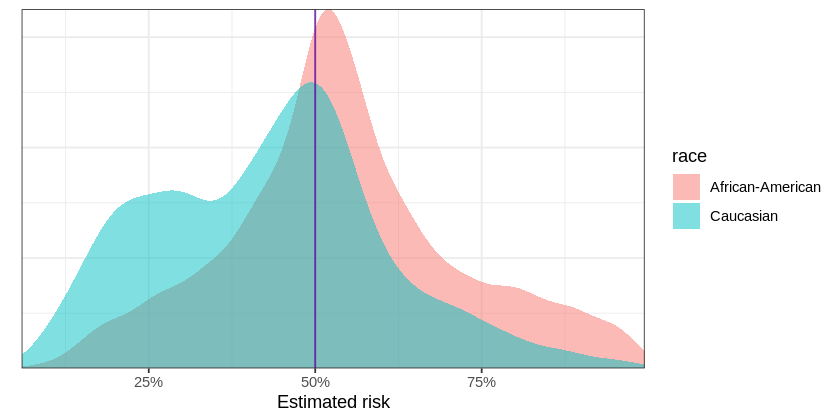

In [41]:
white_threshold = 0.5
black_threshold = 0.5 # Change the thresholds so the FPR are equal

# Calculate detention and recidivism rate by race
compas_df %>%
    mutate(pred_recid = risk > if_else(race == "Caucasian", white_threshold, black_threshold)) %>%
    calc_fpr_fnr()

# See where the thresholds are on the risk distribution
options(repr.plot.width = 7, repr.plot.height = 3.5)

# Recall this risk distribution plot
# Now we add our thresholds in the plots
ggplot(compas_df, aes(x = risk, fill = race)) +
    geom_density(alpha = 0.5, color = NA) +
    scale_x_continuous("Estimated risk", labels = scales::percent_format(), expand = c(0, 0)) +
    scale_y_continuous(element_blank(), expand = c(0, 0)) +
    theme(axis.ticks.y = element_blank(),
          axis.text.y = element_blank())+
    geom_vline(
        xintercept = c(black_threshold, white_threshold), 
        color = c("red", "blue"),
        alpha = 0.5
    )

**Question:** Modify the above code to compute false positive and false negative rates between genders. Do your observations agree with your earlier conclusions about the gender-blind model assigning higher scores to women? Discuss any potential methodological issues in this test.